In [0]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


In [0]:
application_train = pd.read_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/기계학습 프로젝트/#data/application_train.csv', na_values='n/a', index_col="SK_ID_CURR")

In [0]:
application_train.head()

TARGET  ... AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR          ...                           
100002           1  ...                        1.0
100003           0  ...                        0.0
100004           0  ...                        0.0
100006           0  ...                        NaN
100007           0  ...                        0.0

[5 rows x 121 columns]



> # DATA EXPLORATION(시각화)







In [0]:
# divide it into categorials / numerical features
numerical_list = []
categorical_list=[]
for i in application_train.columns.tolist():
    if application_train[i].dtype=='float64':
        numerical_list.append(i)
    else:
        categorical_list.append(i)


In [0]:
df_app_num = application_train[numerical_list].join(application_train.TARGET).dropna(axis=0)

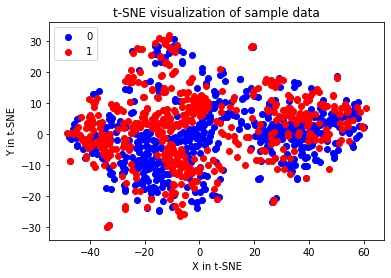

In [0]:
app_1 = df_app_num[df_app_num.TARGET==1].sample(n=500)
app_0 = df_app_num[df_app_num.TARGET==0].sample(n=500)
app_all = pd.concat([app_1, app_0], axis=0)

standard_app_all = StandardScaler().fit_transform(app_all)

y= app_all.TARGET.values
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(standard_app_all)

color_map = {0:'blue', 1:'red'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of sample data')
plt.show()

In [0]:
# Separate data by target value
app_1 = application_train[application_train.TARGET==1]
app_0 = application_train[application_train.TARGET==0]

In [0]:
df_app1 = application_train[['TARGET',
                  'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE']]

In [0]:
# find the outlier's index and put na value
def find_outlier_put_na(data, col, no):
  ind = data.loc[data[col]==no].index
  data[col].loc[ind] = np.nan

In [0]:
#plot the boxplot
def plot_boxplot(data1, data0, col):
  plt.figure(figsize=(10,4))
  plt.subplot(121)
  plt.boxplot(data1[col].dropna(), vert=False)
  plt.title('not paid')
  plt.subplot(122)
  plt.boxplot(data0[col].dropna(), vert=False)
  plt.title('paid')
  plt.show()

In [0]:
#plot the histogram
def plot_histogram(data1, data0, col):
  plt.hist(data1[col], rwidth=0.5, alpha=0.5, label='not repaid')
  plt.hist(data0[col], rwidth=0.5, alpha=0.5, label='paid')
  plt.legend(loc='upper right')
  plt.show()

In [0]:
#plot the histogram with log scale
def plot_histogram_with_log(data1, data0, col):
  plt.hist(np.log(data1[col]), rwidth=0.5, alpha=0.5, label='not repaid')
  plt.hist(np.log(data0[col]), rwidth=0.5, alpha=0.5, label='paid')
  plt.legend(loc='upper right')
  plt.show()

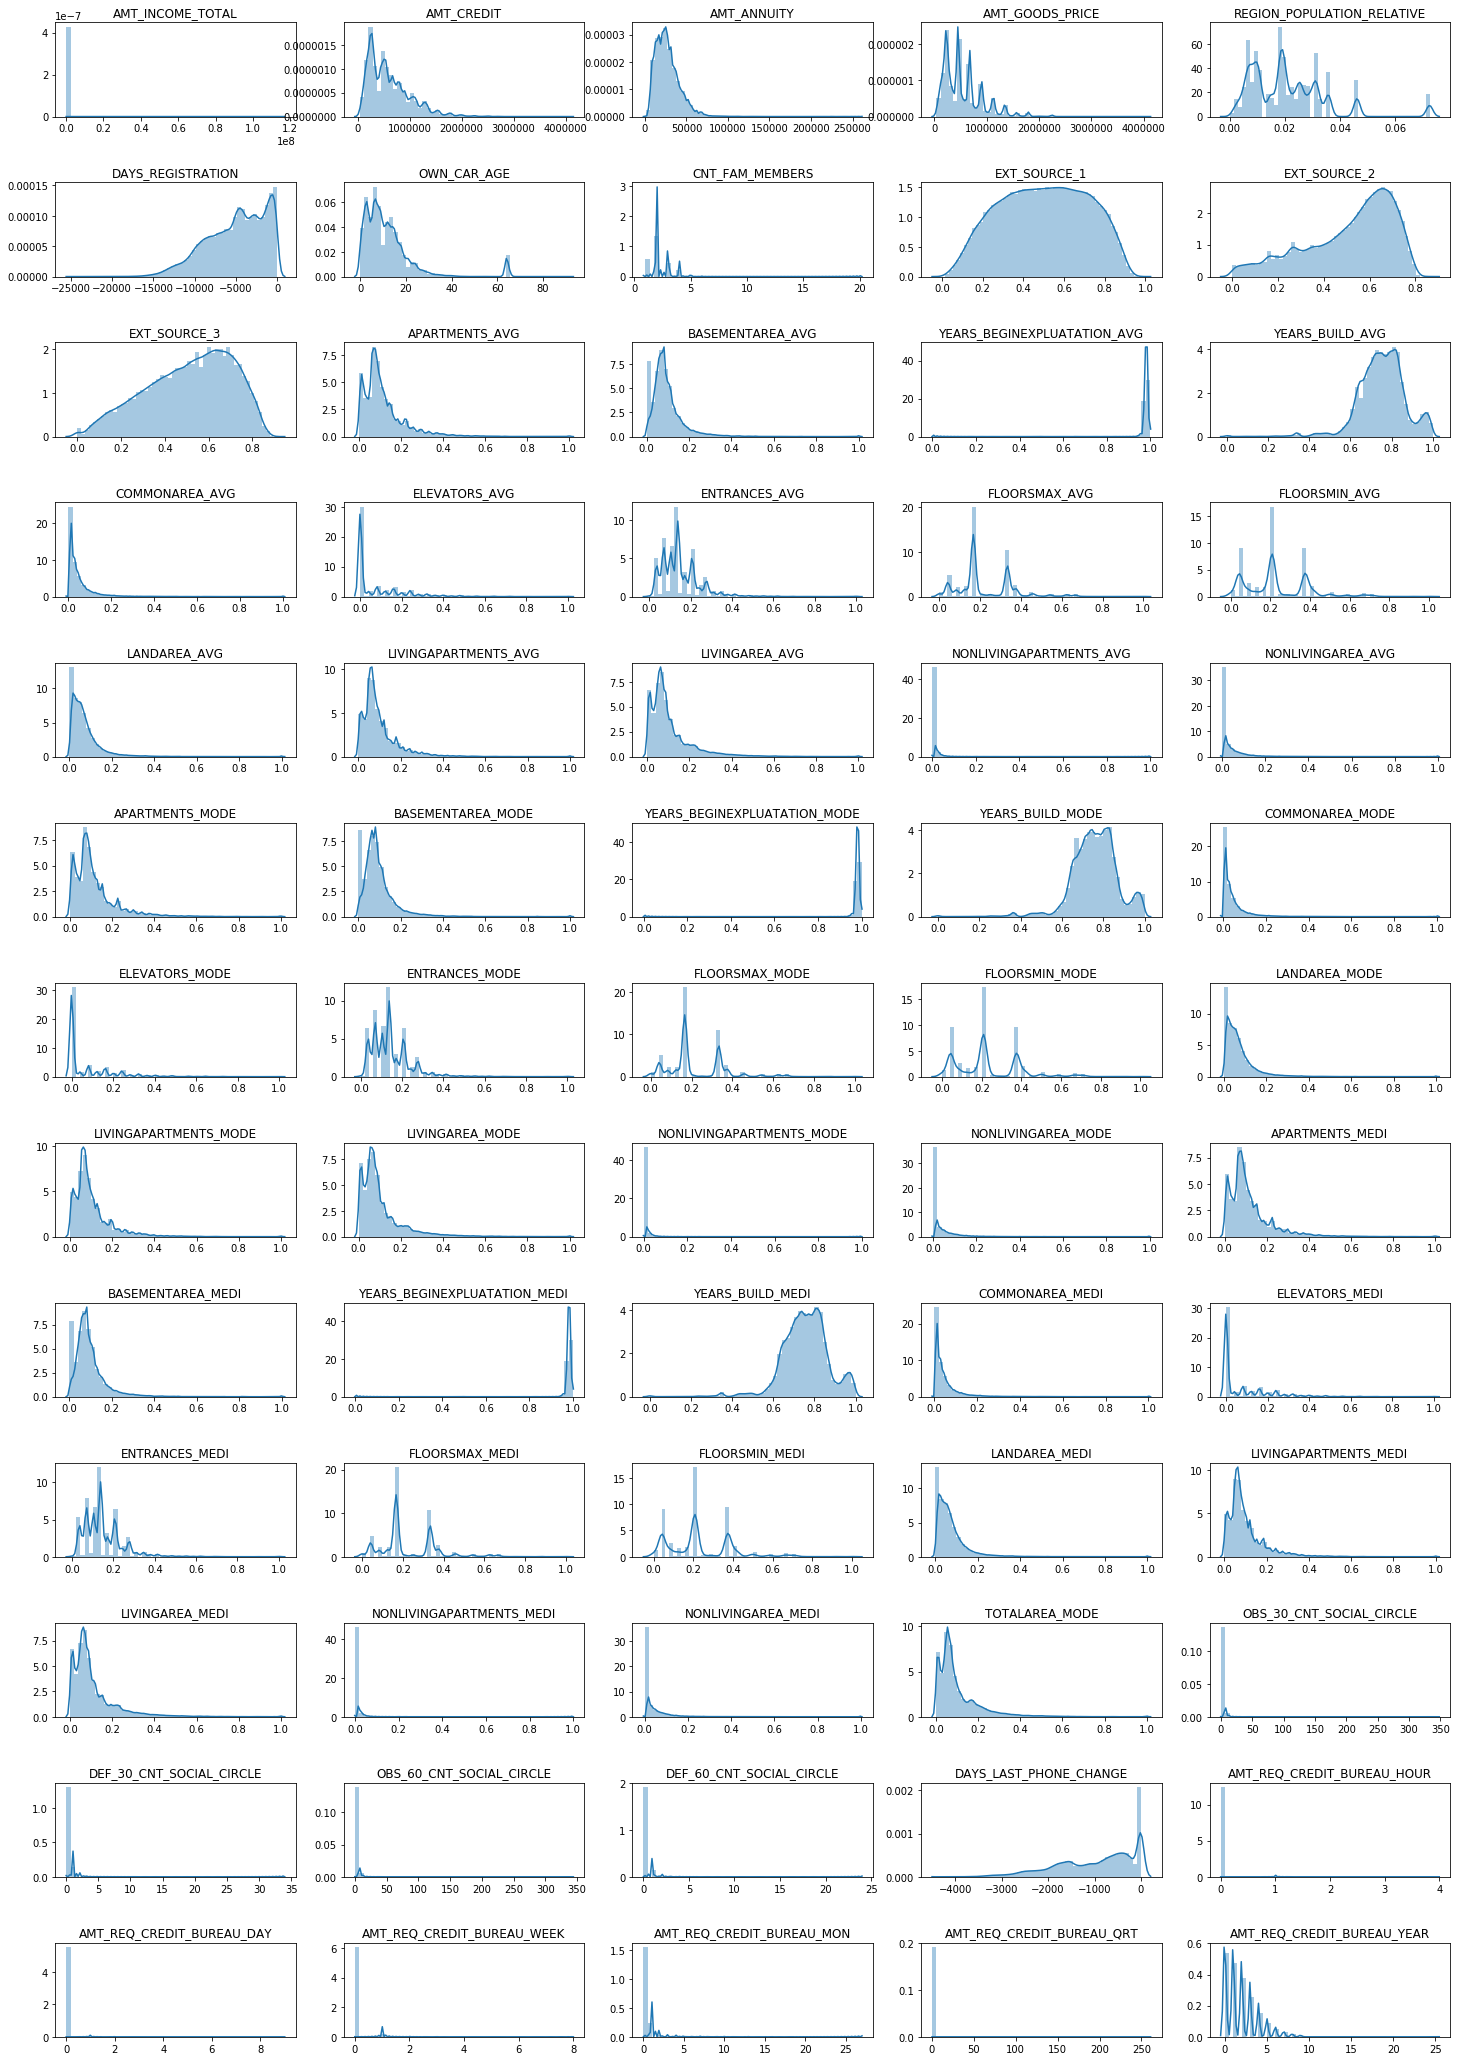

In [0]:
df_app_num = application_train[numerical_list]
fig = plt.figure(figsize=(25,40))
cols = 5
rows = round(len(df_app_num.columns)/cols) + 1
for i, column in enumerate(df_app_num.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    ax = sns.distplot(df_app_num[column])
    plt.xlabel(None)

plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [0]:
#로그스케일 필요
log_list = ['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE'
 ]

df_app_log = np.log(application_train[log_list])
df_app_log

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE
SK_ID_CURR                                                            
100002             12.218495   12.915579    10.114579        12.768542
100003             12.506177   14.072864    10.482864        13.937286
100004             11.119883   11.813030     8.817298        11.813030
100006             11.813030   12.652944    10.298448        12.601487
100007             11.707670   13.148031     9.992665        13.148031
...                      ...         ...          ...              ...
456251             11.967181   12.447842    10.224048        12.323856
456252             11.184421   12.504509     9.392787        12.323856
456253             11.938193   13.426407    10.308252        13.279367
456254             12.049419   12.821547     9.913685        12.674513
456255             11.967181   13.422468    10.801971        13.422468

[307511 rows x 4 columns]

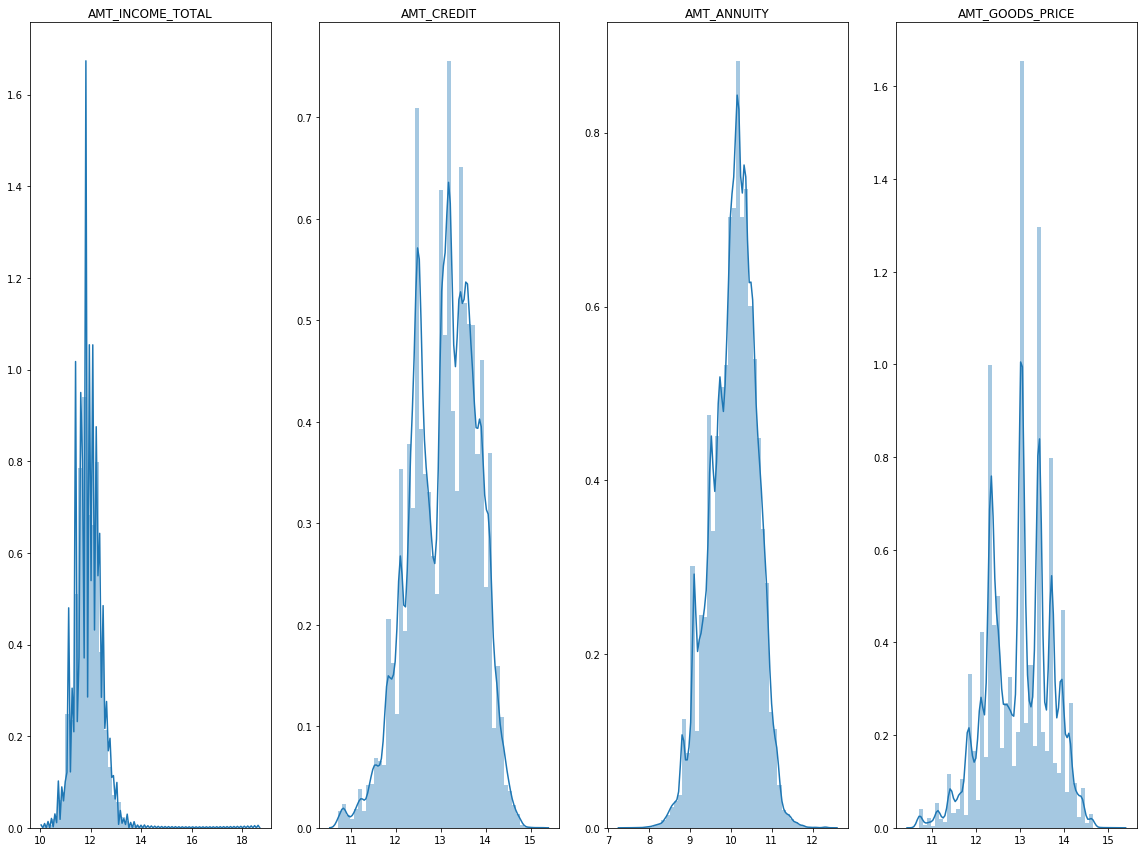

In [0]:
#로그스케일 필요 
fig = plt.figure(figsize=(25,40))
cols = 5
rows = round(len(df_app_log.columns)/cols) + 1
for i, column in enumerate(df_app_log.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    ax = sns.distplot(df_app_log[column])
    plt.xlabel(None)

plt.subplots_adjust(hspace=0.7, wspace=0.2)

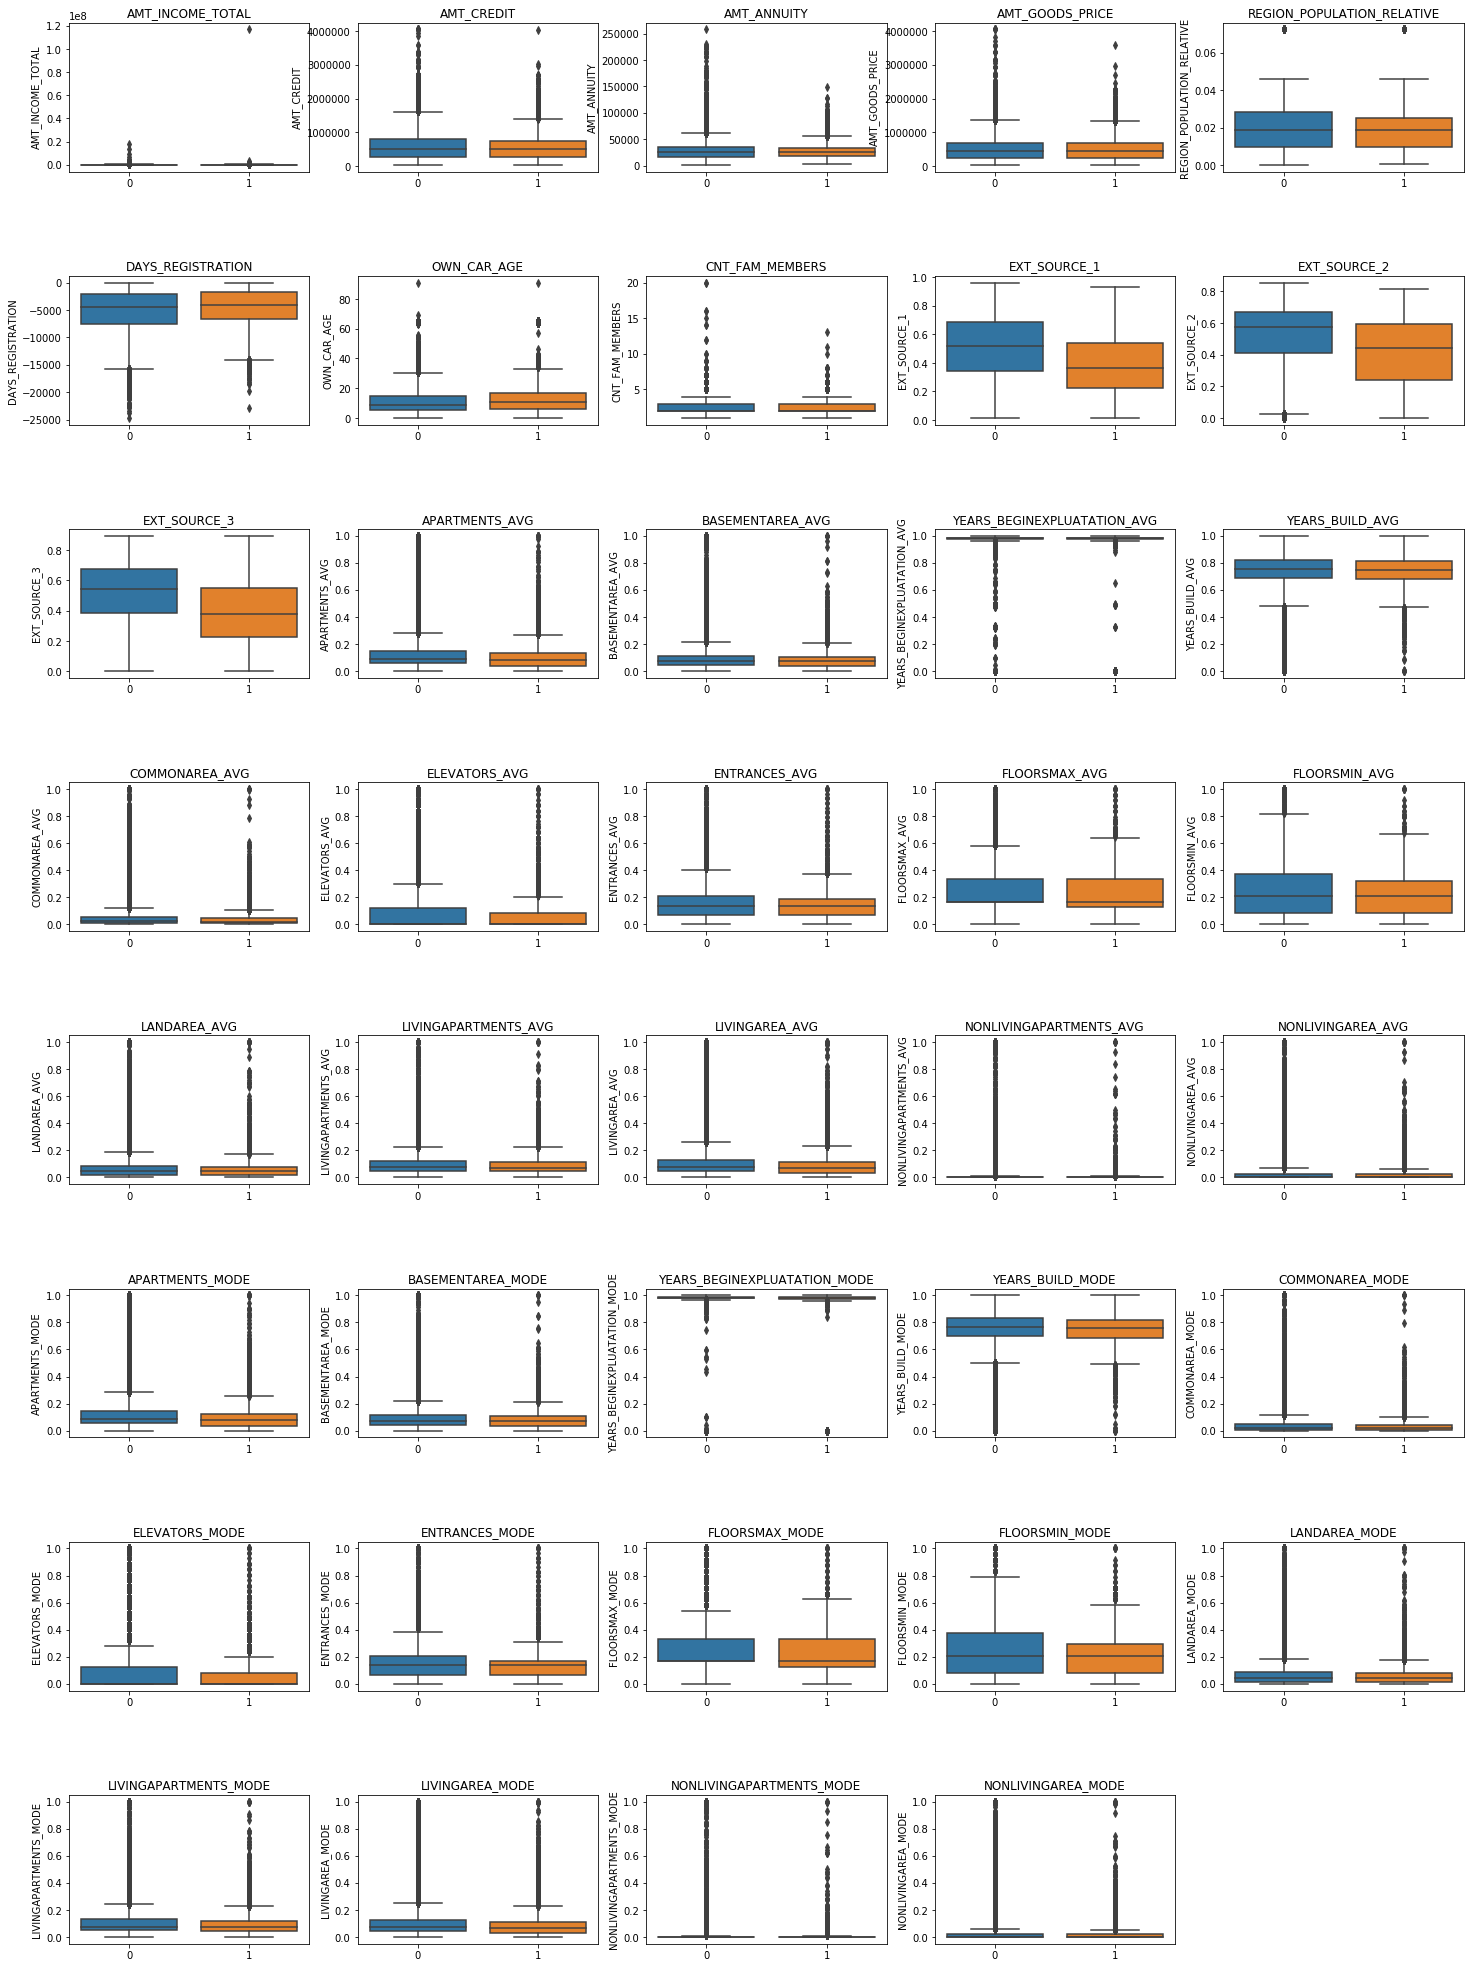

In [0]:
#sns.boxplot(y=df_num['YEARS_BEGINEXPLUATATION_MEDI'],x=df_num['TARGET'],palette='Blues')
fig = plt.figure(figsize=(25,40))
cols = 5
rows = round(len(df_app1.columns)/cols) + 1
for i, column in enumerate(df_app1.columns[1:]):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    ax = sns.boxplot(y=df_app1[column],x=df_app1['TARGET'])
    plt.xlabel(None)

plt.subplots_adjust(hspace=0.7, wspace=0.2)

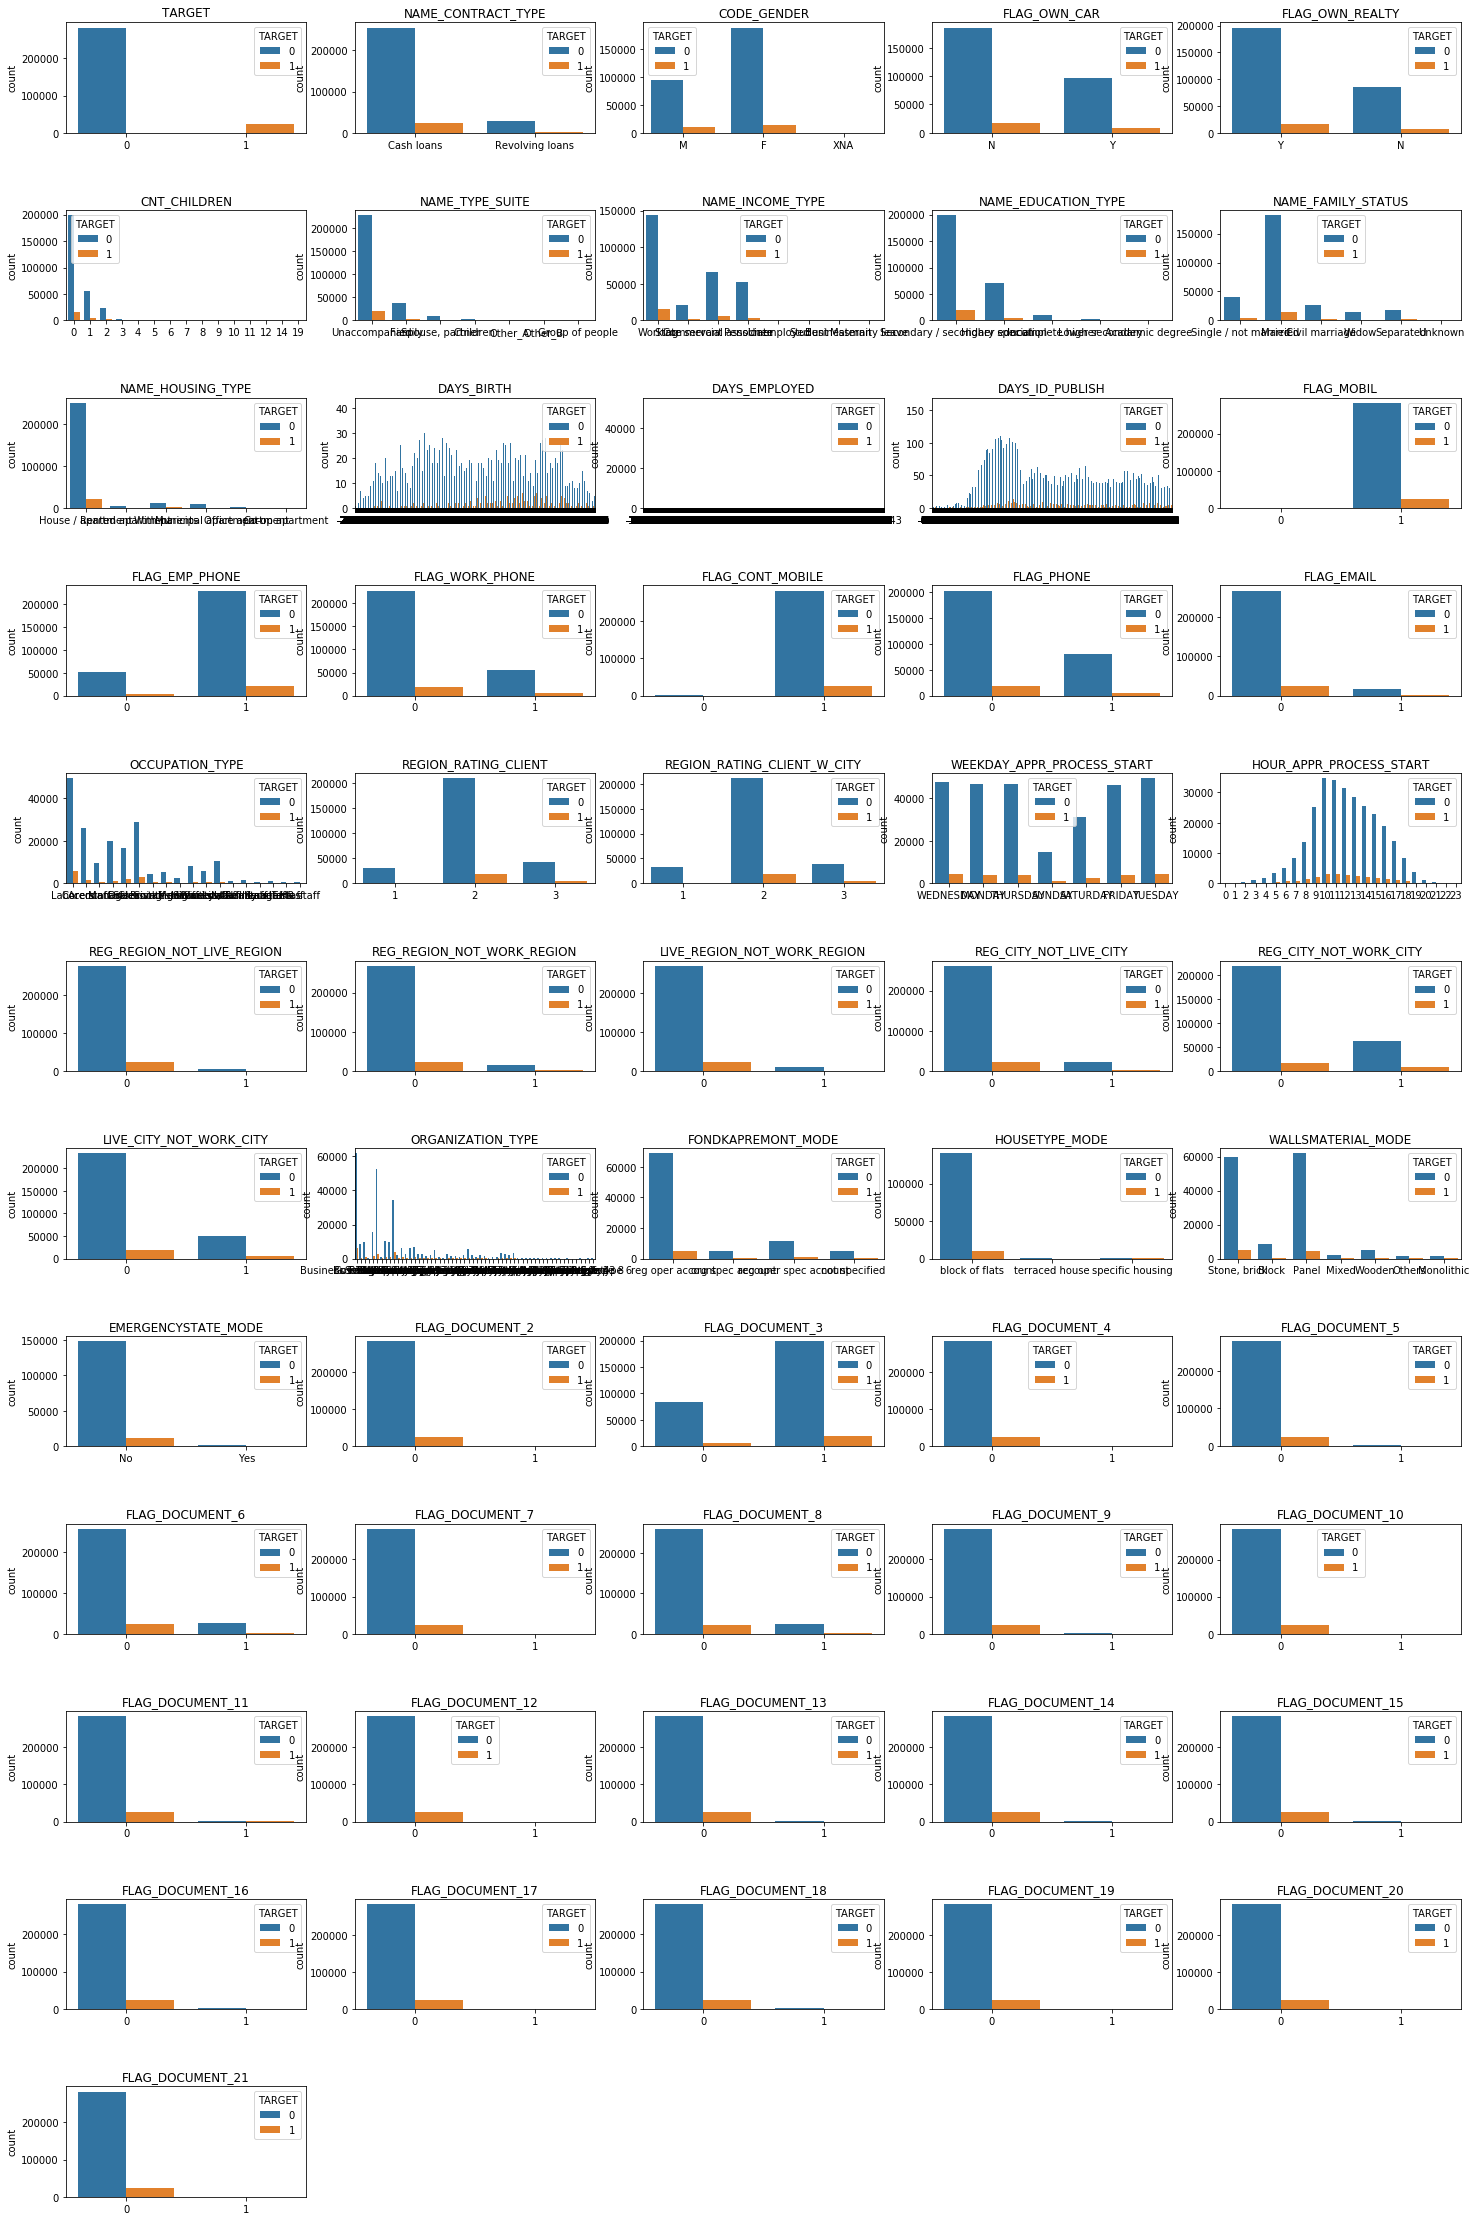

In [0]:
df_app_cat = application_train[categorical_list]
fig = plt.figure(figsize=(25,40))
cols = 5
rows = round(len(df_app_cat.columns)/cols) + 1
for i, column in enumerate(df_app_cat.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    ax = sns.countplot(x=df_app_cat[column],hue='TARGET',data=df_app_cat)
    plt.xlabel(None)

plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [0]:
#heatmap
df_app_num = application_train[numerical_list]

plt.pcolor(df_app_num)
plt.xticks(np.arange(0.5, len(df_app_num.columns), 1), df_app_num.columns)
plt.yticks(np.arange(0.5, len(df_app_num.index), 1), df_app_num.index)
plt.title('Heatmap by plt.pcolor()', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Month', fontsize=14)
plt.colorbar()

plt.show()

In [0]:
ax = sns.heatmap(df_app_num)
plt.title('Heatmap of Flight by seaborn', fontsize=20)
plt.show() 

In [0]:
corr = df_app_num.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr)
#heatmap은 변수 버리고 봐야할듯

# 전처리

In [0]:
#차 소유하지 않았으면 OWN_CAR_AGE = 0 넣기 & nan = 0 넣기
application_train['OWN_CAR_AGE']= application_train['OWN_CAR_AGE'].where(application_train['FLAG_OWN_CAR'] == 'Y', 0)
application_train['OWN_CAR_AGE'] = application_train['OWN_CAR_AGE'].where(application_train['OWN_CAR_AGE'] != np.nan, 0)
application_train['OWN_CAR_AGE'].isnull().sum()

In [0]:
def missing_values_table(df):
    
    # 전체 데이터프레임의 누락된 값 계산
    # Total missing values
    mis_val = df.isnull().sum()
    
    # 누락된 값의 백분율 계산
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 표 작성
    # Make a table with the results
    mis_val_table = pd.concat([mis_val,mis_val_percent], axis=1)
    
    # column명 재정의
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # 내림차순으로 표정렬
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # 요약 정보 출력
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    # 데이터프레임 return
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [0]:
missing_df = missing_values_table(application_train); missing_df

In [0]:
#일단 결측치 50%에서 자르기
na = missing_df[missing_df['% of Total Values'] >= 50]
na = pd.DataFrame(na)
na_list = na.index.values
na_list = na_list.tolist()

In [0]:
df_train = application_train.drop(application_train[na_list], axis=1)

In [0]:
df_train.head()

In [0]:
missing_df = missing_values_table(df_train)
missing_df['Missing Values'].head(40)

In [0]:
df_train["TARGET"].groupby(df_train["TARGET"]).size()

In [0]:
# dataframe of nulls

#replace XNA and blank
df_train = df_train.replace('XNA', np.nan)
df_train = df_train.replace(' ', np.nan)
df_train['DAYS_EMPLOYED'] = (df_train['DAYS_EMPLOYED'].apply(lambda x: x if x != 365243 else np.nan))
df_train.loc[df_train['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
df_train.loc[df_train['AMT_REQ_CREDIT_BUREAU_QRT'] >= 260, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan



In [0]:
#eliminate rows if % of nulls <= 1%
drop_list = ['NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
             'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 
             'CODE_GENDER', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE','OWN_CAR_AGE','AMT_INCOME_TOTAL']
for index in drop_list:
  df_train = df_train[df_train[index].notna()]

count = df_train.isnull().sum().sort_values(ascending=True)
count.tail(40)

In [0]:
df_train["TARGET"].groupby(df_train["TARGET"]).size()

In [0]:
# EXT_SOURCE 결측치 0으로 채우고 summation
df_train['EXT_SOURCE_3'].fillna(0,inplace=True)

#log scale
df_train['AMT_ANNUITY'] = np.log(df_train['AMT_ANNUITY'] )
df_train['AMT_CREDIT'] = np.log(df_train['AMT_CREDIT'])
df_train['AMT_INCOME_TOTAL'] = np.log(df_train['AMT_INCOME_TOTAL'])
df_train['AMT_GOODS_PRICE'] = np.log(df_train['AMT_GOODS_PRICE'])

In [0]:
count = df_train.isnull().sum().sort_values(ascending=True)
count.tail(40)

In [0]:
#주변인 신용도 변수 4개 중 필요없는 열 3개 드랍 #원래는 이거 DROP 인데 PCA 같은거 해보면 괜찮을듯
#df_merged.drop(['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'], axis=1,inplace=True)
#df_merged["OBS_60_CNT_SOCIAL_CIRCLE"] = df_merged["OBS_60_CNT_SOCIAL_CIRCLE"].fillna(df_merged["OBS_60_CNT_SOCIAL_CIRCLE"].mean())

'''#AMT_REQ_CREDIT_BUREAU_? 이건 왜 0으로 채우려고 했었지?
df_merged["AMT_REQ_CREDIT_BUREAU_HOUR"].fillna(0,inplace=True)
df_merged["AMT_REQ_CREDIT_BUREAU_DAY"].fillna(0,inplace=True)
df_merged["AMT_REQ_CREDIT_BUREAU_WEEK"].fillna(0,inplace=True)
df_merged["AMT_REQ_CREDIT_BUREAU_MON"].fillna(0,inplace=True)
df_merged["AMT_REQ_CREDIT_BUREAU_QRT"].fillna(0,inplace=True)
df_merged["AMT_REQ_CREDIT_BUREAU_YEAR"].fillna(0,inplace=True) '''

#월 rate 파악하기
df_train['CREDIT_LENGTH'] = df_train['AMT_CREDIT'] / df_train['AMT_ANNUITY'] 

#XNA => Independent //  OCCUPATION_TYPE <- ORGANIZATION_TYPE 빈도수 많은 걸로 넣기
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].fillna('Independent')
df_train["OCCUPATION_TYPE"] = df_train["OCCUPATION_TYPE"].fillna('Independent')


In [0]:
count = df_train.isnull().sum().sort_values(ascending=True)
count.tail(40)

In [0]:
missings = missing_values_table(df_train)
numerical_list = []
categorical_list=[]

for index in missings.index.tolist():
    print(index)
    if df_train[index].dtype=='float64':
        numerical_list.append(index)
    else:
        categorical_list.append(index)

In [0]:
###numerical###
df_train[numerical_list] = df_train[numerical_list].fillna(0)
#imputer_mean = SimpleImputer(strategy="mean")
#df_app[numerical_list] = imputer_mean.fit_transform(df_app[numerical_list])

###categorical###
df_train.EMERGENCYSTATE_MODE = df_train.EMERGENCYSTATE_MODE.fillna('Independent')


In [0]:
df_train["ORGANIZATION_TYPE"].value_counts()

In [0]:
####NAME_TYPE_SUITE_app####
#Others : Other_A, Other_B, Group of people
#Heart : Children, Family, (Spouse, partner)
#0 : na values

df_train["NAME_TYPE_SUITE"] = df_train["NAME_TYPE_SUITE"].replace('Other_A','Others').replace('Other_B','Others').replace('Group of people','Others')
df_train["NAME_TYPE_SUITE"] = df_train["NAME_TYPE_SUITE"].replace('Children','Heart').replace('Family','Heart').replace('Spouse, partner','Heart')
#df_merged["NAME_TYPE_SUITE_app"].fillna(0,inplace=True)`


df_train["NAME_INCOME_TYPE"] = df_train["NAME_INCOME_TYPE"].replace('Commercial associate','Working').replace('State servant','Working').replace('Businessman','Working')
df_train["NAME_INCOME_TYPE"] = df_train["NAME_INCOME_TYPE"].replace('Student','not_working').replace('Maternity leave','not_working').replace('Unemployed','not_working')


df_train["NAME_EDUCATION_TYPE"] = df_train["NAME_EDUCATION_TYPE"].replace('Secondary / secondary special','Middle').replace('Incomplete higher','Middle')
df_train["NAME_EDUCATION_TYPE"] = df_train["NAME_EDUCATION_TYPE"].replace('Academic degree','High').replace('Higher education','High')
df_train["NAME_EDUCATION_TYPE"] = df_train["NAME_EDUCATION_TYPE"].replace('Lower secondary','Lower')


#### NAME_FAMILY_STATUS ####
# Ect: Single / not married, Separated, 'Widow
# Civil marriage
# Married
# 0 : unknown

df_train["NAME_FAMILY_STATUS"] = df_train["NAME_FAMILY_STATUS"].replace('Single / not married','Etc').replace('Separated','Etc').replace('Widow','Etc')
df_train["NAME_FAMILY_STATUS"] = df_train["NAME_FAMILY_STATUS"].replace('Unknown','0')


###OCCUPATION_TYPE###
df_train["OCCUPATION_TYPE"] = df_train["OCCUPATION_TYPE"].replace('Waiters/barmen staff','Low').replace('Low-skill Laborers','Low').replace('Drivers','Low').replace('Cleaning staff','Low').replace('Laborers','Low').replace('Cooking staff','Low').replace('Security staff','Low')
df_train["OCCUPATION_TYPE"] = df_train["OCCUPATION_TYPE"].replace('HR staff','Middle').replace('IT staff','Middle').replace('Managers','Middle').replace('Core staff','Middle').replace('Sales staff','Middle').replace('Private service staff','Middle').replace('Secretaries','Middle').replace('Realty agents','Middle')
df_train["OCCUPATION_TYPE"] = df_train["OCCUPATION_TYPE"].replace('Medicine staff','High').replace('Accountants','High').replace('High skill tech staff','High')


######ORGANIZATION_TYPE######
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Industry: type 8','Industry').replace('Industry: type 10','Industry').replace('Industry: type 13','Industry').replace('Industry: type 6','Industry').replace('Industry: type 12','Industry').replace('Industry: type 4','Industry').replace('Industry: type 9','Industry').replace('Industry: type 3','Industry')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Industry: type 11','Industry').replace('Industry: type 7','Industry').replace('Industry: type 1','Industry').replace('Industry: type 5','Industry').replace('Industry: type 2','Industry')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Trade: type 5','Trade').replace('Trade: type 4','Trade').replace('Trade: type 1','Trade').replace('Trade: type 6','Trade').replace('Trade: type 2','Trade').replace('Trade: type 3','Trade').replace('Trade: type 7','Trade')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Business Entity Type 1','Business').replace('Business Entity Type 2','Business').replace('Business Entity Type 3','Business')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Transport: type 1','Transport').replace('Transport: type 2','Transport').replace('Transport: type 3','Transport').replace('Transport: type 4','Transport')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Kindergarten','School').replace('University','School')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Security Ministries','Security')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Government','public').replace('Military','public').replace('Police','public').replace('Postal','public')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Emergency','Medicine')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Insurance','Finance').replace('Bank','Finance').replace('Realtor','Finance')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Religion','Culture')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Telecom','Mobile')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Cleaning','Services').replace('Legal Services','Services').replace('Hotel','Services').replace('Restaurant','Services')
df_train["ORGANIZATION_TYPE"] = df_train["ORGANIZATION_TYPE"].replace('Advertising','Other').replace('Electricity','Other').replace('Agriculture','Other').replace('Housing','Other').replace('Construction','Other')



In [0]:
df_train["ORGANIZATION_TYPE"].value_counts()

In [0]:
df_train.head()

In [0]:
##FLAG_DOCUMENT summation => 얘는 아직 확실하지 않아서 안햇음


#summation 결과, 새로운 행 만들기
df_train['FLAG_DOCUMENT'] = df_train[['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
  'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
  'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
  'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']].sum(axis=1)

In [0]:
#기존 document 행 드랍
 df_train = df_train.drop(['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
  'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
  'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
  'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'], axis=1)

#summation 결과, 1보다 큰 값들 1로 바꾸기
#df_train['FLAG_DOCUMENT'][df_train['FLAG_DOCUMENT'] >=1] =1
#df_train['FLAG_DOCUMENT'].value_counts()

In [0]:
df_train.head()

In [0]:
#summation 결과, 새로운 행 만들기
 #df_merged['AMT_REQ_CREDIT_BUREAU'] = df_merged[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
#                                                 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)
#기존 req_credit 행 드랍
 #df_merged =  df_merged.drop(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
  #                                              'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1)

TRANSFORM CAT INTO CATEGORICAL

In [0]:
# 별도 구간 설정 필요 없는 애들을 Categorical로 변환
df_train['LIVE_CITY_NOT_WORK_CITY'] = pd.Categorical(df_train.LIVE_CITY_NOT_WORK_CITY)
df_train['LIVE_REGION_NOT_WORK_REGION'] = pd.Categorical(df_train.LIVE_REGION_NOT_WORK_REGION)
df_train['REGION_RATING_CLIENT'] = pd.Categorical(df_train.REGION_RATING_CLIENT)
df_train['REGION_RATING_CLIENT_W_CITY'] = pd.Categorical(df_train.REGION_RATING_CLIENT_W_CITY)
df_train['REG_CITY_NOT_LIVE_CITY'] = pd.Categorical(df_train.REG_CITY_NOT_LIVE_CITY)
df_train['REG_CITY_NOT_WORK_CITY'] = pd.Categorical(df_train.REG_CITY_NOT_WORK_CITY)
df_train['REG_REGION_NOT_LIVE_REGION'] = pd.Categorical(df_train.REG_REGION_NOT_LIVE_REGION)
df_train['REG_REGION_NOT_WORK_REGION'] = pd.Categorical(df_train.REG_REGION_NOT_WORK_REGION)

In [0]:
# DAYS_EMPLOYED
de = df_train['DAYS_EMPLOYED']
de_bins = np.digitize(de, bins= [0, 1])  #n개
empl = ['min', 'zero', 'plus']   # n+1 개
df_de= [empl[i] for i in de_bins]
df_train['DAYS_EMPLOYED'] = df_de

In [0]:
df_train['DAYS_EMPLOYED'].isnull().sum()

In [0]:
# 'CNT_CHILDREN
child = df_train['CNT_CHILDREN']
num_child = np.digitize(child, bins= [0,1,2])
ran_child= ['NoKid', 'OneKid', 'TwoKids', 'OverTwo']
df_child= [ran_child[i] for i in num_child]

df_train['CNT_CHILDREN'] = df_child

In [0]:
df_train['CNT_CHILDREN'].isnull().sum()

In [0]:
# 'DAYS_BIRTH': 나이를 연령대로 구간화해서 Categorical로 변환
dbirth = df_train['DAYS_BIRTH']

day_bins = np.digitize(dbirth, bins= [-21900,-18250,-14600,-10950])
time = ['60s', '50s', '40s', '30s', '20s']
df_dbirth= [time[i] for i in day_bins]

df_train['DAYS_BIRTH'] = df_dbirth
df_train['DAYS_BIRTH'].isnull().sum()

In [0]:
# 'DAYS_ID_PUBLISH'
id_publish = df_train['DAYS_ID_PUBLISH'] #df변경

num_bins = np.digitize(id_publish, bins= [-7000,-6500])
time = ['Over19.1','Middle', 'Under17.8']
lst_id_publish= [time[i] for i in num_bins]

df_train['DAYS_ID_PUBLISH'] = lst_id_publish
df_train['DAYS_BIRTH'].isnull().sum()

In [0]:
# 'HOUR_APPR_PROCESS_START_app'
hour_appr = df_train['HOUR_APPR_PROCESS_START']
num_bins = np.digitize(hour_appr, bins= [7,15])
time = ['Midnight','AM', 'PM']
df_hour= [time[i] for i in num_bins]
df_train['HOUR_APPR_PROCESS_START'] = df_hour

In [0]:
df_train['HOUR_APPR_PROCESS_START'].isnull().sum()

In [0]:
#확인용: ['SK_ID_CURR','TARGET',  'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT'] 이면 ok
df1 = [col for col in df_train.columns if df_train[col].dtype == 'int64']
df1

In [0]:
missing_values_table(df_train)

In [0]:
df_train['REGION_RATING_CLIENT'] = df_train['REGION_RATING_CLIENT'].astype('str')
df_train['REGION_RATING_CLIENT_W_CITY'] = df_train['REGION_RATING_CLIENT_W_CITY'].astype('str')

# ONEHOTENCODING

In [0]:
def categoricalDumm(df):
    x= pd.DataFrame()
    df_1= [col for col in df.columns if df[col].dtype == "object"]
    df_2= df[df_1]
    df_dummy = pd.get_dummies(df_2)
    x= pd.concat([x,df_dummy],axis=1)
    df=df.drop(columns= df_1)
    df= pd.concat([df,x], axis=1)
    return df

In [0]:
df_train = categoricalDumm(df_train)

In [0]:
df_train.head()

# scale

In [0]:
num_cols = df_train._get_numeric_data().columns 
num_ccols = num_cols.drop(['TARGET','FLAG_MOBIL'])

In [0]:
from sklearn.preprocessing import MinMaxScaler
X_num = df_train[num_ccols]
df_train[num_ccols] = MinMaxScaler().fit_transform(X_num)

In [0]:
df_train.head()

In [0]:
missing_values_table(df_train)

# 데이터 저장

In [0]:
df_train.to_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/기계학습 프로젝트/#data/df_complex2.csv')

# 변수선택 및 차원축소

In [0]:
df_complex = pd.read_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/기계학습 프로젝트/#data/df_complex.csv', na_values='n/a', index_col="SK_ID_CURR")

In [0]:
df_complex = df_complex.drop('CODE_GENDER_F',axis=1)
df_complex = df_complex.drop('HOUR_APPR_PROCESS_START_AM',axis=1)
df_complex = df_complex.drop('FLAG_OWN_CAR_N',axis=1)
df_complex = df_complex.drop('FLAG_OWN_REALTY_N',axis=1)
df_complex = df_complex.drop('OBS_30_CNT_SOCIAL_CIRCLE',axis=1)
df_complex = df_complex.drop('DEF_30_CNT_SOCIAL_CIRCLE',axis=1)
df_complex = df_complex.drop('NAME_FAMILY_STATUS_Etc',axis=1)
df_complex = df_complex.drop('NAME_EDUCATION_TYPE_Middle',axis=1)
df_complex = df_complex.drop('NAME_TYPE_SUITE_Unaccompanied',axis=1)
df_complex = df_complex.drop('FLAG_EMP_PHONE',axis=1)
df_complex = df_complex.drop('ORGANIZATION_TYPE_Independent',axis=1)
df_complex = df_complex.drop('DAYS_EMPLOYED_zero',axis=1)
df_complex = df_complex.drop('NAME_INCOME_TYPE_Pensioner',axis=1)

In [0]:
df_complex

In [0]:
from sklearn.decomposition import PCA

In [0]:
index = df_complex.index.to_list()

In [0]:
#적절한 차원수 선택 #0.95 일떄는 1개만
pca = PCA(n_components=0.95)
X_proj = pca.fit_transform(df_complex[['AMT_CREDIT', 'AMT_ANNUITY','AMT_GOODS_PRICE']])
print('principal component vec :\n', pca.components_.T)

principalDf = pd.DataFrame(data = X_proj, columns = ['pc 1(loan)', 'pc 2(loan)'],index=index)

In [0]:
df_complex['pc loan1'] = principalDf.iloc[:,0]
df_complex['pc loan2'] = principalDf.iloc[:,1]

In [0]:
df_complex = df_complex.drop('AMT_GOODS_PRICE',axis=1)
df_complex = df_complex.drop('AMT_CREDIT',axis=1)
df_complex = df_complex.drop('AMT_ANNUITY',axis=1)

In [0]:
#적절한 차원수 선택 #0.95 일떄는 1개만
pca = PCA(n_components=0.95)
X_proj = pca.fit_transform(df_complex[['YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE','YEARS_BEGINEXPLUATATION_MEDI','FLOORSMAX_MEDI', 'EMERGENCYSTATE_MODE_Independent','EMERGENCYSTATE_MODE_No', 'TOTALAREA_MODE']])
print('principal component vec :\n', pca.components_.T)

principalDf = pd.DataFrame(data = X_proj
             , columns = ['pc 1(house)'],index=index)

In [0]:
df_complex['pc house'] = principalDf.iloc[:,0]

In [0]:
df_complex = df_complex.drop('YEARS_BEGINEXPLUATATION_AVG',axis=1)
df_complex = df_complex.drop('FLOORSMAX_AVG',axis=1)
df_complex = df_complex.drop('FLOORSMAX_MODE',axis=1)
df_complex = df_complex.drop('YEARS_BEGINEXPLUATATION_MEDI',axis=1)
df_complex = df_complex.drop('FLOORSMAX_MEDI',axis=1)
df_complex = df_complex.drop('EMERGENCYSTATE_MODE_Independent',axis=1)
df_complex = df_complex.drop('EMERGENCYSTATE_MODE_No',axis=1)
df_complex = df_complex.drop('TOTALAREA_MODE',axis=1)

In [0]:
#적절한 차원수 선택 0.95 일떄는 1개만
pca = PCA(n_components=0.95)
X_proj = pca.fit_transform(df_complex[['REGION_RATING_CLIENT_1', 'REGION_RATING_CLIENT_W_CITY_1','REGION_RATING_CLIENT_2', 'REGION_RATING_CLIENT_W_CITY_2','REGION_RATING_CLIENT_3', 'REGION_RATING_CLIENT_W_CITY_3']])
print('principal component vec :\n', pca.components_.T)

principalDf = pd.DataFrame(data = X_proj
             , columns = ['pc 1(live)','pc 2(live)'],index=index)

In [0]:
df_complex['pc live1'] = principalDf.iloc[:,0]
df_complex['pc live2'] = principalDf.iloc[:,1]

In [0]:
df_complex = df_complex.drop('REGION_RATING_CLIENT_1',axis=1)
df_complex = df_complex.drop('REGION_RATING_CLIENT_W_CITY_1',axis=1)
df_complex = df_complex.drop('REGION_RATING_CLIENT_2',axis=1)
df_complex = df_complex.drop('REGION_RATING_CLIENT_W_CITY_2',axis=1)
df_complex = df_complex.drop('REGION_RATING_CLIENT_3',axis=1)
df_complex = df_complex.drop('REGION_RATING_CLIENT_W_CITY_3',axis=1)

변수 선택

In [0]:
X_num = df_complex[['pc loan1','pc loan2','pc house', 'pc live1','pc live2']]
X_num_norm = MinMaxScaler().fit_transform(X_num)

df_complex[['pc loan1','pc loan2','pc house', 'pc live1','pc live2']] = X_num_norm
df_complex.head()

In [0]:
# Create correlation matrix
corr_matrix = df_complex.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
df_complex =  df_complex.drop(df_complex[to_drop], axis=1)

In [0]:
X = df_complex.drop(['TARGET'], axis=1)
y = df_complex.TARGET
feature_name = X.columns.tolist()

1.Filter

In [0]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-50:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [0]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

1.2 chi-2

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

chi_selector = SelectKBest(chi2, k=50)
chi_selector.fit(X, y)

In [0]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

2. Wrapper

2.1 RFE

In [0]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=50, step=10, verbose=5)
rfe_selector.fit(X, y)

In [0]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(list(rfe_feature))

3.Embedded

3.1 Logistic Regression

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embedded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), '1.25*median')
embedded_lr_selector.fit(X, y)

In [0]:
embedded_lr_support = embedded_lr_selector.get_support()
embedded_lr_feature = X.loc[:,embedded_lr_support].columns.tolist()
print(str(len(embedded_lr_feature)), 'selected features')

3.2 Random Forest

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embedded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=50), threshold='1.25*median')
embedded_rf_selector.fit(X, y)

In [0]:
embedded_rf_support = embedded_rf_selector.get_support()
embedded_rf_feature = X.loc[:,embedded_rf_support].columns.tolist()
print(str(len(embedded_rf_feature)), 'selected features')

3.3 LightGBM

In [0]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embedded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embedded_lgb_selector.fit(X, y)

In [0]:
embedded_lgb_support = embedded_lgb_selector.get_support()
embedded_lgb_feature = X.loc[:,embedded_lgb_support].columns.tolist()
print(str(len(embedded_lgb_feature)), 'selected features')

Summary

In [0]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embedded_lr_support,
                                    'Random Forest':embedded_rf_support, 'LightGBM':embedded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 50
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(50)

In [0]:
# final feature selection (# of Trues for 6 feature selection models >= 4)

feature_selection_df = feature_selection_df.drop(feature_selection_df.index[36:], axis=0)
feature_selection_df

In [0]:
#The list of selected feature
feature_selection_df.to_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/기계학습 프로젝트/#data/complex1_fs_list.csv')

In [0]:
# final selected dataframe
df_complex_selected = df_complex[feature_selection_df.Feature.tolist()]
df_complex_selected.head()

In [0]:
df_complex_selected = df_complex_selected.merge(df_complex.TARGET, on='SK_ID_CURR')

In [0]:
df_complex_selected.head()

In [0]:
df_complex_selected.to_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/기계학습 프로젝트/#data/complex_final.csv')

# 모델 및 샘플링